# Calculate normalization stats per timestamp 

```
#
# Copyright (c) Sinergise, 2019 -- 2021.
#
# This file belongs to subproject "field-delineation" of project NIVA (www.niva4cap.eu).
# All rights reserved.
#
# This source code is licensed under the MIT license found in the LICENSE
# file in the root directory of this source tree.
#
```

This notebook computes the normalisation factors per band per month for the `.npz` files obtained so far. These normalisation factors are saved to `.csv` file and will be used at training and validation of the model.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tqdm.auto import tqdm

from fd.compute_normalization import (ComputeNormalizationConfig, 
                                      stats_per_npz_ts, 
                                      prepare_filesystem,
                                      concat_npz_results,
                                      create_per_band_norm_dataframe)
from fd.utils import multiprocess

### Configuration

In [3]:
config = ComputeNormalizationConfig(
    bucket_name='bucket-name',
    aws_access_key_id='',
    aws_secret_access_key='',
    aws_region='eu-central-1',
    npz_files_folder='data/Castilla/2020-04/patchlets_npz',
    metadata_file='metadata/Castilla/2020-04/patchlet-info.csv')

In [4]:
filesystem = prepare_filesystem(config)

In [5]:
npz_files = filesystem.listdir(config.npz_files_folder)
len(npz_files)

375

In [6]:
partial_fn = partial(stats_per_npz_ts, config=config)
results = multiprocess(partial_fn, npz_files, max_workers=24)

In [7]:
# choose here which stats you are interested in from
# ['mean', 'std', 'median', 'minimum', 'maximum', 'perc_1', 'perc_5', 'perc_95', 'perc_99']
stats_keys = ['mean', 'std', 'median', 'perc_99']
identifier_keys = ['timestamp', 'patchlet'] 

concatenated_stats = {}

for key in stats_keys+identifier_keys: 
    concatenated_stats[key] = concat_npz_results(key, results)

Compute normalisations factors

In [8]:
df = create_per_band_norm_dataframe(concatenated_stats, stats_keys, identifier_keys)

In [9]:
df.head()

,mean_b0,mean_b1,mean_b2,mean_b3,std_b0,std_b1,std_b2,std_b3,median_b0,median_b1,median_b2,median_b3,perc_99_b0,perc_99_b1,perc_99_b2,perc_99_b3,timestamp,patchlet
0,946.885086,903.584335,782.504227,2508.395584,149.192150,176.107406,285.188017,551.064050,901.0,860.0,702.0,2388.0,1541.00,1604.65,1859.65,3996.65,2020-03-25 00:00:00+00:00,data/Castilla/2020-04/patchlets/29TPE_8_0_0
1,1052.747513,1001.685013,879.340103,2822.341324,161.609392,190.444790,311.382746,572.298422,1001.5,952.0,792.0,2706.0,1684.00,1737.00,2014.00,4345.00,2020-03-27 00:00:00+00:00,data/Castilla/2020-04/patchlets/29TPE_8_0_0
2,951.282150,915.464325,789.655685,2611.258011,142.239637,163.911497,265.487987,559.593806,911.0,882.0,726.0,2525.0,1553.00,1599.30,1831.00,3977.65,2020-03-25 00:00:00+00:00,data/Castilla/2020-04/patchlets/29TPE_8_0_1
3,1053.198975,1013.473846,880.672379,2945.391541,151.519767,172.964569,285.056535,587.179160,1010.0,976.0,814.0,2859.0,1687.65,1724.65,1996.00,4374.65,2020-03-27 00:00:00+00:00,data/Castilla/2020-04/patchlets/29TPE_8_0_1
4,907.313629,854.274582,729.555573,2400.836746,89.188441,119.730080,202.790544,550.307150,889.0,842.0,691.0,2324.0,1264.00,1309.00,1497.65,3831.00,2020-03-25 00:00:00+00:00,data/Castilla/2020-04/patchlets/29TPE_8_0_2


In [10]:
len(df)

18701

In [11]:
df.columns

Index(['mean_b0', 'mean_b1', 'mean_b2', 'mean_b3', 'std_b0', 'std_b1',
       'std_b2', 'std_b3', 'median_b0', 'median_b1', 'median_b2', 'median_b3',
       'perc_99_b0', 'perc_99_b1', 'perc_99_b2', 'perc_99_b3', 'timestamp',
       'patchlet'],
      dtype='object')

## Analysis

In [12]:
# convert to datetime
timestamps = df['timestamp'].apply(lambda d: d.tz_localize(None))
df['timestamp']=timestamps.astype(np.datetime64)

# add "month" period
df['month']=df.timestamp.dt.to_period("M")

#### Distributions of means, percentiles, etc...

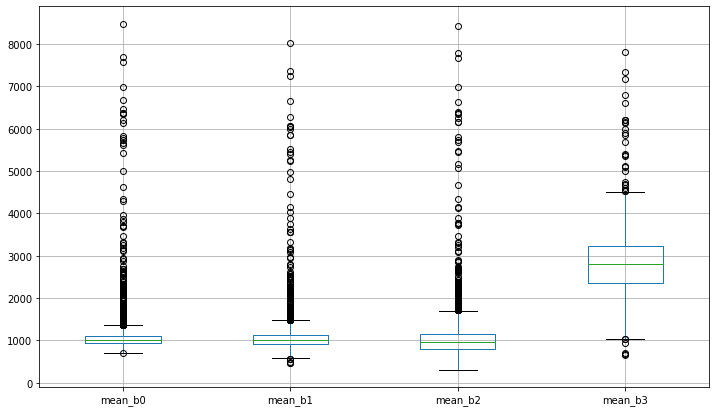

In [13]:
df[['mean_b0','mean_b1','mean_b2','mean_b3']].plot.box(figsize=(12,7))
plt.grid()

In [14]:
def plot_distributions(dataframe, stat, stat_title=None):
    colors = ['b','g','r','y']
    bands = list(range(4))
    
    if not stat_title:
        stat_title = stat

    log=True
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18,13))
    for band in bands:
        dataframe.hist(f'{stat}_b{band}', ax=ax[0], range=(0,10000),
                       bins=100, log=log, color=colors[band], 
                       alpha=0.3, label=f'b{band}')
    ax[0].legend()
    ax[0].grid(axis='x')
    ax[0].set_title(f'Histograms of {stat_title}');

    log=False
    for band in bands:
        dataframe.hist(f'{stat}_b{band}', cumulative=True,  range=(0,10000),
                       density=True, ax=ax[1], bins=100, log=log, 
                       color=colors[band], alpha=0.3, label=f'b{band}')
    ax[1].legend()
    ax[1].grid(axis='x')
    ax[1].set_title(f'Cumulative distributions of {stat_title}');

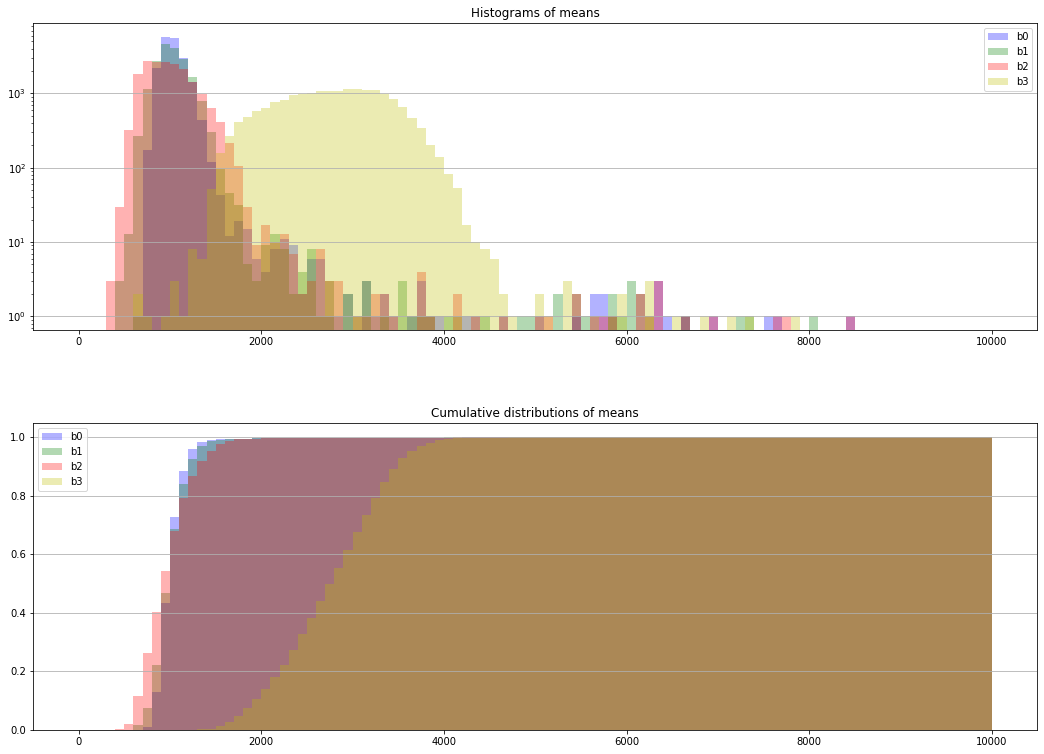

In [15]:
plot_distributions(df, 'mean','means')

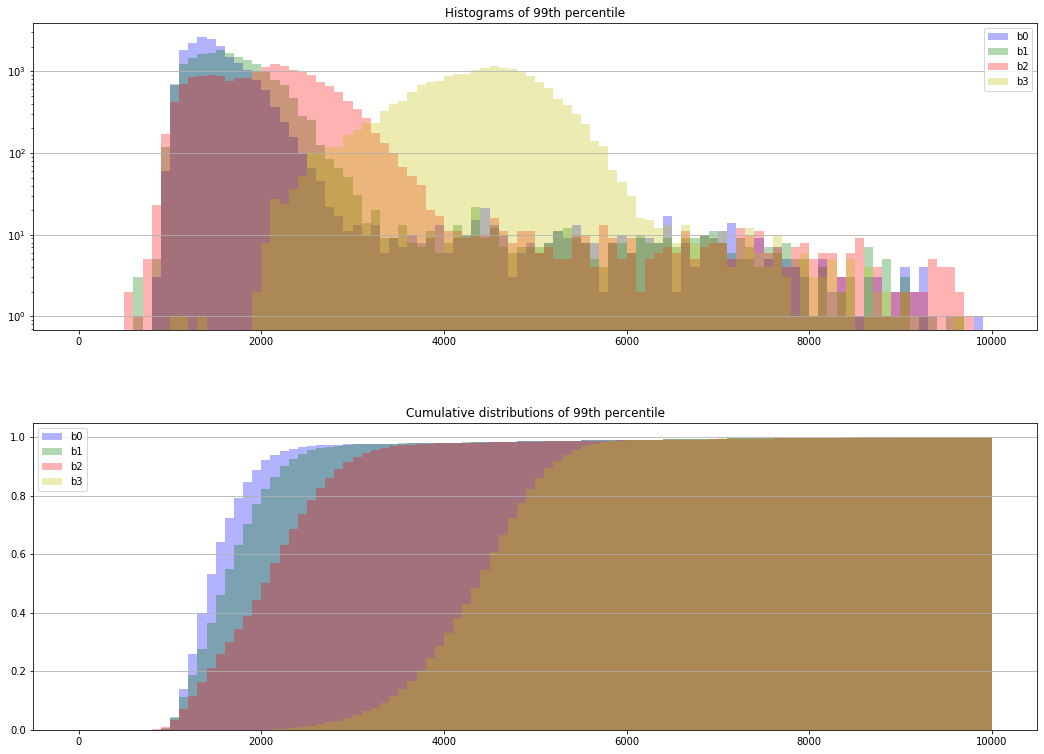

In [16]:
plot_distributions(df, 'perc_99','99th percentile')

### How do distributions change through time?

In [17]:
aggs = {}
stat_cols = []
stats = ['perc_99', 'mean', 'median', 'std']
bands = list(range(4))
for stat in stats:
    for band in bands:
        aggs[f'{stat}_b{band}'] = [np.std, np.mean];
        stat_cols.append(f'{stat}_b{band}')

In [18]:
monthly = pd.DataFrame(df.groupby('month', as_index=False)[stat_cols].agg(aggs))
monthly.columns = ['_'.join(col).strip() for col in monthly.columns.values]
monthly.rename(columns={'month_':'month'}, inplace=True)

In [19]:
monthly

,month,perc_99_b0_std,perc_99_b0_mean,perc_99_b1_std,perc_99_b1_mean,perc_99_b2_std,perc_99_b2_mean,perc_99_b3_std,perc_99_b3_mean,mean_b0_std,...,median_b3_std,median_b3_mean,std_b0_std,std_b0_mean,std_b1_std,std_b1_mean,std_b2_std,std_b2_mean,std_b3_std,std_b3_mean
0,2020-03,837.730768,1638.926083,841.789106,1772.954155,961.121666,2152.593251,761.059352,4336.044875,267.102707,...,656.813094,2726.109618,180.141939,175.795333,182.023552,232.388964,219.556844,382.406135,170.996348,649.973699
1,2020-04,863.307149,1604.478170,842.563854,1727.987483,916.052722,2129.344945,756.629591,4284.482495,230.771027,...,541.938729,2573.705866,221.178547,180.552451,216.019736,231.539699,242.735397,391.280970,192.079813,630.743793
2,2020-05,346.415728,1621.392147,463.660352,1822.890925,713.700773,2228.282952,706.157404,4607.050465,112.469334,...,570.328830,3020.553016,85.619009,174.398337,115.969952,232.913813,204.160287,407.725960,157.471701,600.311697


In [20]:
def monthly_stats(monthly_df, stat, stat_title=None):
    fig, ax = plt.subplots(figsize=(12,9))
    cols = ['b','g','r','y']
    
    if not stat_title:
        stat_title = stat
        
    for band in range(4):
        x_vals = np.array([m.month for m in monthly_df['month']])
        ax.plot(x_vals, monthly_df[f'{stat}_b{band}_mean'].values, 
                color=cols[band], label=f'band {band}')
        ax.fill_between(x_vals, 
                        monthly_df[f'{stat}_b{band}_mean'].values - 
                        monthly_df[f'{stat}_b{band}_std'].values, 
                        monthly_df[f'{stat}_b{band}_mean'].values + 
                        monthly_df[f'{stat}_b{band}_std'].values, color=cols[band], 
                        alpha=0.2)

    ax.legend()
    ax.grid()
    ax.set_title(f'{stat_title} through months')

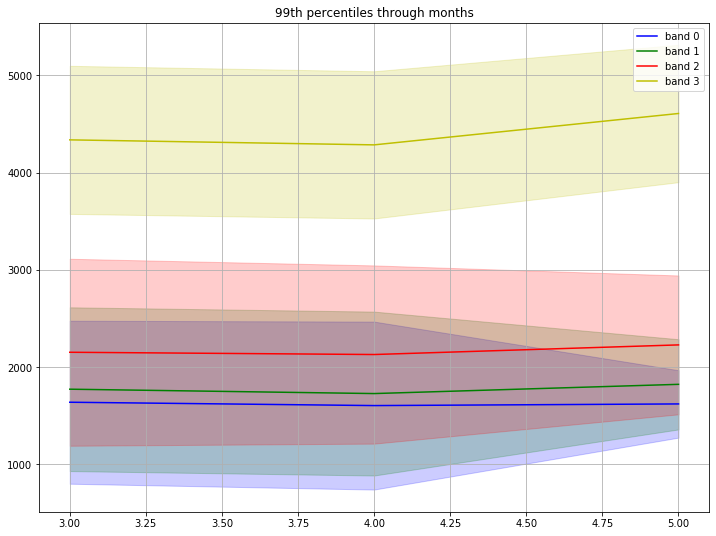

In [21]:
monthly_stats(monthly, 'perc_99', '99th percentiles')

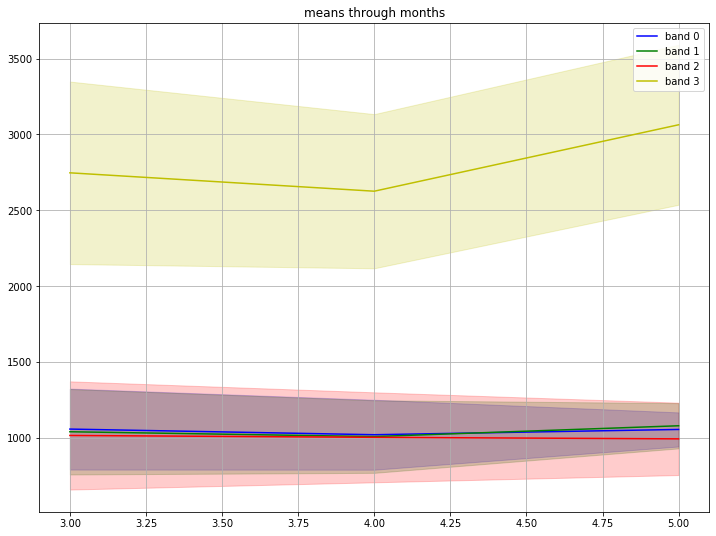

In [22]:
monthly_stats(monthly, 'mean', 'means')

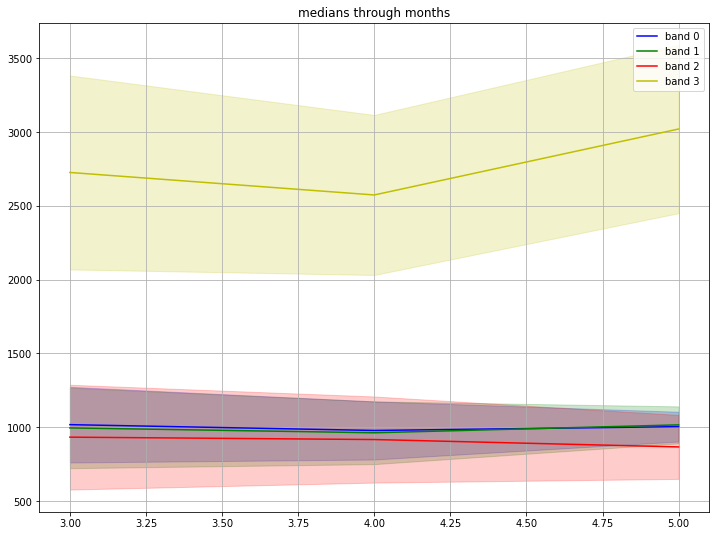

In [23]:
monthly_stats(monthly, 'median', 'medians')

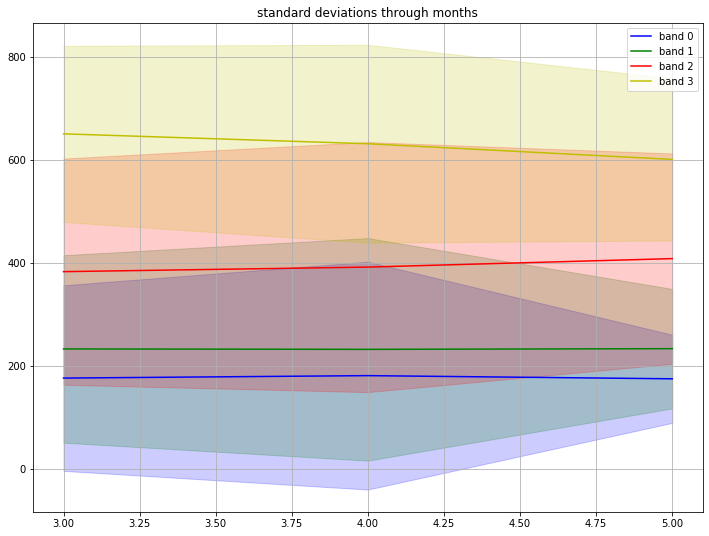

In [24]:
monthly_stats(monthly, 'std', 'standard deviations')

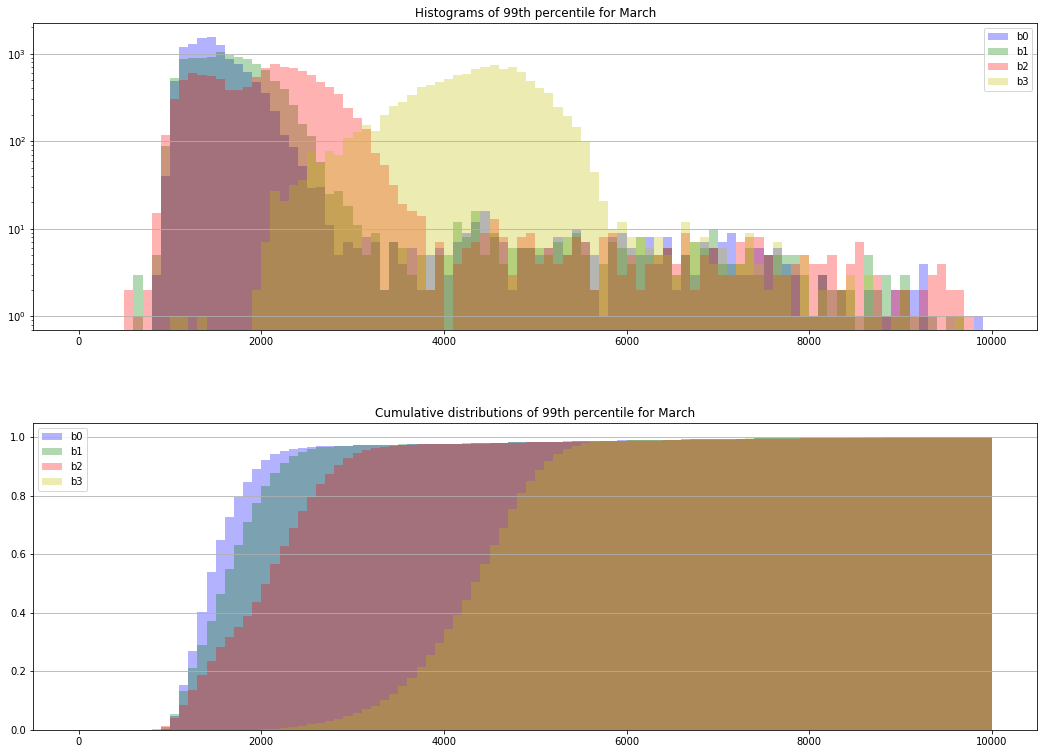

In [25]:
plot_distributions(df.loc[df.month=='2020-03'], 'perc_99', '99th percentile for March')

## Calculate normalization factors per month per band

We calculate normalization factors for two different normalizations: `perc99` and `meanstd`. To normalize using `perc99` one would just divide the band values with `norm_perc99_b{band}` value, while for normalization with mean and standard deviation two parameters are needed (per band): `norm_meanstd_mean_b{band}` and `norm_meanstd_std_b{band}`.

In [26]:
norm_cols = [norm.format(band) 
             for norm in ['perc_99_b{0}_mean', 
                          'mean_b{0}_mean', 
                          'median_b{0}_mean', 
                          'std_b{0}_mean'] for band in range(4)]

def norms(month):
    return monthly.loc[monthly.month==month][norm_cols].values[0]

In [27]:
df['norm_perc99_b0'], df['norm_perc99_b1'], df['norm_perc99_b2'], df['norm_perc99_b3'], \
df['norm_meanstd_mean_b0'], df['norm_meanstd_mean_b1'], df['norm_meanstd_mean_b2'], df['norm_meanstd_mean_b3'], \
df['norm_meanstd_median_b0'], df['norm_meanstd_median_b1'], df['norm_meanstd_median_b2'], df['norm_meanstd_median_b3'], \
df['norm_meanstd_std_b0'], df['norm_meanstd_std_b1'], df['norm_meanstd_std_b2'], df['norm_meanstd_std_b3'] = zip(*map(norms, df.month))

In [28]:
df[['month','norm_perc99_b0','norm_perc99_b1','norm_perc99_b2','norm_perc99_b3']].drop_duplicates()

,month,norm_perc99_b0,norm_perc99_b1,norm_perc99_b2,norm_perc99_b3
0,2020-03,1638.926083,1772.954155,2152.593251,4336.044875
150,2020-04,1604.478170,1727.987483,2129.344945,4284.482495
173,2020-05,1621.392147,1822.890925,2228.282952,4607.050465


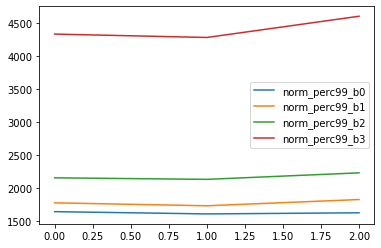

In [29]:
# this plot should reflect solid lines from `monthly_stats(monthly, 'perc_99','99th percentiles')`
df[['month','norm_perc99_b0','norm_perc99_b1','norm_perc99_b2','norm_perc99_b3']].drop_duplicates().reset_index(drop=True).plot()

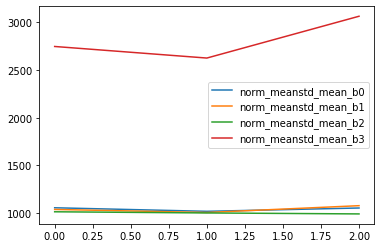

In [30]:
# another check; should be similar to `monthly_stats(monthly, 'mean','means')`
df[['month','norm_meanstd_mean_b0','norm_meanstd_mean_b1','norm_meanstd_mean_b2','norm_meanstd_mean_b3']].drop_duplicates().reset_index(drop=True).plot()

## Add this info to patchlet info

In [31]:
df.columns

Index(['mean_b0', 'mean_b1', 'mean_b2', 'mean_b3', 'std_b0', 'std_b1',
       'std_b2', 'std_b3', 'median_b0', 'median_b1', 'median_b2', 'median_b3',
       'perc_99_b0', 'perc_99_b1', 'perc_99_b2', 'perc_99_b3', 'timestamp',
       'patchlet', 'month', 'norm_perc99_b0', 'norm_perc99_b1',
       'norm_perc99_b2', 'norm_perc99_b3', 'norm_meanstd_mean_b0',
       'norm_meanstd_mean_b1', 'norm_meanstd_mean_b2', 'norm_meanstd_mean_b3',
       'norm_meanstd_median_b0', 'norm_meanstd_median_b1',
       'norm_meanstd_median_b2', 'norm_meanstd_median_b3',
       'norm_meanstd_std_b0', 'norm_meanstd_std_b1', 'norm_meanstd_std_b2',
       'norm_meanstd_std_b3'],
      dtype='object')

In [32]:
len(df)

18701

In [33]:
with filesystem.open(config.metadata_file, 'rb') as fcsv:
    df_info = pd.read_csv(fcsv)

In [34]:
df_info['timestamp'] = pd.to_datetime(df_info.timestamp)

In [35]:
timestamps = df_info['timestamp'].apply(lambda d: d.tz_localize(None))
df_info['timestamp'] = timestamps.astype(np.datetime64)

In [36]:
df_info.head()

,chunk,eopatch,patchlet,chunk_pos,timestamp
0,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_0,0,2020-03-25
1,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_0,1,2020-03-27
2,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_1,2,2020-03-25
3,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_1,3,2020-03-27
4,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_2,4,2020-03-25


In [37]:
new_df = df_info.merge(df, how='inner', on=['patchlet', 'timestamp'])

In [38]:
len(new_df)

18701

In [39]:
new_df.head()

,chunk,eopatch,patchlet,chunk_pos,timestamp,mean_b0,mean_b1,mean_b2,mean_b3,std_b0,...,norm_meanstd_mean_b2,norm_meanstd_mean_b3,norm_meanstd_median_b0,norm_meanstd_median_b1,norm_meanstd_median_b2,norm_meanstd_median_b3,norm_meanstd_std_b0,norm_meanstd_std_b1,norm_meanstd_std_b2,norm_meanstd_std_b3
0,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_0,0,2020-03-25,946.885086,903.584335,782.504227,2508.395584,149.192150,...,1014.02099,2746.590043,1017.891939,995.769063,933.1703,2726.109618,175.795333,232.388964,382.406135,649.973699
1,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_0,1,2020-03-27,1052.747513,1001.685013,879.340103,2822.341324,161.609392,...,1014.02099,2746.590043,1017.891939,995.769063,933.1703,2726.109618,175.795333,232.388964,382.406135,649.973699
2,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_1,2,2020-03-25,951.282150,915.464325,789.655685,2611.258011,142.239637,...,1014.02099,2746.590043,1017.891939,995.769063,933.1703,2726.109618,175.795333,232.388964,382.406135,649.973699
3,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_1,3,2020-03-27,1053.198975,1013.473846,880.672379,2945.391541,151.519767,...,1014.02099,2746.590043,1017.891939,995.769063,933.1703,2726.109618,175.795333,232.388964,382.406135,649.973699
4,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_2,4,2020-03-25,907.313629,854.274582,729.555573,2400.836746,89.188441,...,1014.02099,2746.590043,1017.891939,995.769063,933.1703,2726.109618,175.795333,232.388964,382.406135,649.973699


Overwrite `.csv` file

In [40]:
with filesystem.open(config.metadata_file, 'w') as fcsv:
    new_df.to_csv(fcsv, index=False)